# Analysis

This notebook contains the analysis of the cleaned dataset, the genre, and topic classes

In [1]:
import pandas as pd
import tiktoken
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from helper_functions import get_tokens_symbols, files_to_df_func, files_to_df_core_func
import tiktoken

from dotenv import load_dotenv, find_dotenv
load_dotenv()

directory = './data/ncse_text_chunks'

dev_transcripts = 'data/dev_data_transcript'

dev_gpt4_results = 'data/dev_data_gpt-4-turbo-preview'
dev_gpt3_results = 'data/dev_data_gpt-3.5-turbo'

save_figs = os.getenv("save_figs")


overproof_folder = 'data/overproof'
smh_folder =  os.path.join(overproof_folder, 'SMH')
smh_articles_raw = os.path.join(smh_folder, 'article_level', 'raw')
smh_articles_transcribed = os.path.join(smh_folder, 'article_level', 'corrected') #in the dataset they are reffered to as corrected but this clashes with my naming convention
smh_articles_results = os.path.join(smh_folder, 'results')

ca_folder =  os.path.join(overproof_folder, 'CA')
ca_articles_raw = os.path.join(ca_folder, 'article_level', 'raw')
ca_articles_transcribed = os.path.join(ca_folder, 'article_level', 'corrected') #in the dataset they are reffered to as corrected but this clashes with my naming convention
ca_articles_results = os.path.join(ca_folder, 'results')


transcripts_path = "data/transcription_returned_ocr/transcription_files"#dev_transcripts

model_name_code = pd.Series(
    {'Llama 2 70B':'llama2-70b-4096',
 'Gemma 7B':'gemma-7b-it',
 'Opus':'claude-3-opus-20240229',
 'Haiku':'haiku',
 'GPT-4':'gpt-4-turbo-preview',
 'GPT-3.5':'gpt-3.5-turbo',
 'Mixtral 8x7B':'mixtral-8x7b-32768'})



# Basic data set information

This section just provides basic information about the dataset for the methods section of the paper

In [2]:
periodicals_page_df = pd.read_parquet('./data/periodicals_page.parquet').rename(columns={'number':'page_number'})
periodicals_page_df = periodicals_page_df[['id', 'page_number']]

periodicals_publication_df = pd.read_parquet('./data/periodicals_publication.parquet')

periodicals_publication_df['title'] = periodicals_publication_df['title'].str.replace(r"\s\(\d{4}\-\d{4}\)", "", regex=True)

periodicals_publication_df= periodicals_publication_df.sort_values('year_from')

periodicals_publication_df['years'] = periodicals_publication_df['year_from'].astype(str) +'-'+ periodicals_publication_df['year_to'].astype(str)

periodicals_publication_df#[['title', 'years', 'issue_count', 'article_count']]

,id,abbreviation,slug,title,description,ordering,title_image,year_from,year_to,issue_count,page_count,article_count,headnotes_url,weekly,years
5,22,MRUC,mruc,Monthly Repository and Unitarian Chronicle,,1806,monthly-respository.jpg,1806,1837,487,26783,51202,/headnotes/mrp.html,False,1806-1837
0,27,NS,ns,Northern Star,,1837,northern-star.jpg,1837,1852,2201,17853,230596,/headnotes/nss.html,True,1837-1852
1,20,L,l,Leader,,1850,leader.jpg,1850,1860,1011,24456,162431,/headnotes/ldr.html,True,1850-1860
4,24,EWJ,ewj,English Woman’s Journal,,1858,english-womens-journal.jpg,1858,1864,91,5663,8061,/headnotes/ewj.html,False,1858-1864
2,19,T,t,Tomahawk,,1867,tomahawk.jpg,1867,1870,188,2125,12825,/headnotes/ttw.html,True,1867-1870
3,26,PC,pc,Publishers’ Circular,,1880,publishers-circular.jpg,1880,1890,285,20827,56739,/headnotes/tec.html,True,1880-1890


In [3]:

token_symbols_df  = get_tokens_symbols(directory)

FileNotFoundError: [Errno 2] No such file or directory: './data/ncse_text_chunks'

In [4]:
periodicals_page_df = pd.read_parquet('./data/periodicals_page.parquet').rename(columns={'number':'page_number'})
periodicals_page_df = periodicals_page_df[['id', 'page_number']]

periodicals_publication_df = pd.read_parquet('./data/periodicals_publication.parquet')

periodicals_publication_df['title'] = periodicals_publication_df['title'].str.replace(r"\s\(\d{4}\-\d{4}\)", "", regex=True)

periodicals_publication_df= periodicals_publication_df.sort_values('year_from')

periodicals_publication_df['Years'] = periodicals_publication_df['year_from'].astype(str) +'-'+ periodicals_publication_df['year_to'].astype(str)

periodicals_publication_df = periodicals_publication_df.merge(token_symbols_df.groupby('publication_id')[['total_tokens']].sum(), left_on='id', right_on = 'publication_id')

periodicals_publication_df = periodicals_publication_df[['title', 'Years', 'issue_count', 'article_count', 'total_tokens']].rename(columns = {
    'issue_count':'Issues', 'article_count':'Articles (k)', 'total_tokens':'Tokens (M)',
    'title':'Title'
})

periodicals_publication_df['Articles (k)'] = (periodicals_publication_df['Articles (k)']/1e3).round().astype(int)
periodicals_publication_df['Tokens (M)'] = (periodicals_publication_df['Tokens (M)']/1e6).round().astype(int)
#periodicals_publication_df['Tokens/Article'] = (periodicals_publication_df['Tokens (M)']*1e3  /periodicals_publication_df['Articles (k)']).round().astype(int)


periodicals_publication_df

column_format = 'p{5cm}lrrr'  # 'p{5cm}' for Title, 'l' for Impact Factor, 'r' for ISSN
latex_table = periodicals_publication_df.to_latex(index=False, caption="The periodicals in the NCSE and their key information", label="tab:periodicals_table", column_format=column_format)
print(latex_table)

NameError: name 'token_symbols_df' is not defined

## The test Dataset

In [5]:
def render_latex_with_formatting(df, caption, label):

    df = df.copy()
    # Format the 'Total' row by appending \textbf{} to each element
    df.iloc[-1] = df.iloc[-1].apply(lambda x: '\\textbf{' + str(x) + '}')
    
    # Convert DataFrame to LaTeX
    latex_table = df.to_latex(
        index=False,
        escape=False,  # Important to render LaTeX commands within the table properly
        column_format='p{5cm}cccc',  # One left-aligned column followed by four centered columns
        bold_rows=True,  # Bold the headers
        caption=caption,
        label=label
    )
    return latex_table


def calculate_totals(dataset, title):
    totals = {
        'title': title,
        'unique_rows': dataset['file_name'].nunique(),
        'total_words': dataset['word_count'].sum(),
        'total_tokens': dataset['tokens'].sum()
    }

    # Calculate the weighted mean of tokens
    weighted_sum = (dataset.groupby('file_name')['tokens'].sum() * dataset.groupby('file_name')['tokens'].count()).sum()
    totals['mean_tokens'] = weighted_sum / totals['unique_rows']

    totals_df = pd.DataFrame([totals], index=["Total"])

    return totals_df

In [6]:
test_dataset = files_to_df_func(transcripts_path)

enc = tiktoken.encoding_for_model("gpt-3.5-turbo") 
test_dataset['word_count'] = test_dataset['content'].apply(lambda x: len(str(x).split()))
test_dataset['tokens'] = test_dataset['content'].apply(lambda row: len(enc.encode(row)))
test_dataset['slug'] = test_dataset['file_name'].apply(
    lambda x: x.split('periodical_')[1].split('_')[0] if 'periodical_' in x else None
)

# Aggregating data by 'periodical_id'
test_dataset_g = test_dataset.groupby('slug').agg(
    unique_rows=pd.NamedAgg(column='file_name', aggfunc='nunique'),  # Count unique rows based on 'file_name'
    total_words=pd.NamedAgg(column='word_count', aggfunc='sum'),     # Sum of all words
    total_tokens=pd.NamedAgg(column='tokens', aggfunc='sum'),        # Sum of all tokens
    mean_tokens=pd.NamedAgg(column='tokens', aggfunc='mean')         # Mean of tokens
)

totals = {
    'title': 'Total',
    'unique_rows': test_dataset['file_name'].nunique(),
    'total_words': test_dataset['word_count'].sum(),
    'total_tokens': test_dataset['tokens'].sum()
}

# Calculate the weighted mean of tokens
weighted_sum = (test_dataset.groupby('file_name')['tokens'].sum() * test_dataset.groupby('file_name')['tokens'].count()).sum()
totals['mean_tokens'] = weighted_sum / totals['unique_rows']

# Create a DataFrame from the totals with an appropriate index
totals_df = pd.DataFrame([totals], index=["Total"])



# Display the aggregated DataFrame
test_dataset_g = periodicals_publication_df[['slug', 'title']].copy().merge(test_dataset_g.reset_index(), left_on = 'slug', right_on = 'slug').drop(columns='slug')

# Append the totals row to the grouped DataFrame
test_dataset = pd.concat([test_dataset_g, totals_df], ignore_index=True)

#del test_dataset_g

test_dataset['mean_tokens'] = test_dataset['mean_tokens'].round().astype(int)

test_dataset = test_dataset.rename(columns={
    'title':'Title',
    'unique_rows': 'Articles',
    'total_words': 'Words',
    'total_tokens': 'Tokens',
    'mean_tokens': 'Mean Tokens'

})

test_dataset


,Title,Articles,Words,Tokens,Mean Tokens
0,Monthly Repository and Unitarian Chronicle,11,2777,3549,323
1,Northern Star,15,13237,16329,1089
2,Leader,9,7946,9983,1109
3,English Woman’s Journal,8,4035,5038,630
4,Tomahawk,30,5775,8698,290
5,Publishers’ Circular,7,2455,5086,727
6,Total,80,36225,48683,609


In [15]:


latex_table = render_latex_with_formatting(test_dataset, 'Summary Statistics of the dataset by periodical', 'tab:final_dataset_stats')
print(latex_table)

\begin{table}
\caption{Summary Statistics of the dataset by periodical}
\label{tab:final_dataset_stats}
\begin{tabular}{p{5cm}cccc}
\toprule
Title & Articles & Words & Tokens & Mean Tokens \\
\midrule
Monthly Repository and Unitarian Chronicle & 11 & 2777 & 3549 & 323 \\
Northern Star & 15 & 13237 & 16329 & 1089 \\
Leader & 9 & 7946 & 9983 & 1109 \\
English Woman’s Journal & 8 & 4035 & 5038 & 630 \\
Tomahawk & 4 & 996 & 1362 & 340 \\
Publishers’ Circular & 7 & 2455 & 5086 & 727 \\
\textbf{Total} & \textbf{54} & \textbf{31446} & \textbf{41347} & \textbf{766} \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_422821/1654396009.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{54}' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[-1] = df.iloc[-1].apply(lambda x: '\\textbf{' + str(x) + '}')
/tmp/ipykernel_422821/1654396009.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{31446}' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[-1] = df.iloc[-1].apply(lambda x: '\\textbf{' + str(x) + '}')
/tmp/ipykernel_422821/1654396009.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{41347}' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[-1] = df.iloc[-1].apply(lambda x: '\

# Overproof

This is the table of the overproof dataset

In [16]:
smh_details_df = files_to_df_core_func(smh_articles_transcribed)

enc = tiktoken.encoding_for_model("gpt-3.5-turbo") 
smh_details_df['word_count'] = smh_details_df['content'].apply(lambda x: len(str(x).split()))
smh_details_df['tokens'] = smh_details_df['content'].apply(lambda row: len(enc.encode(row)))

totals = {
    'title':"Sydney Morning Herald",
    'unique_rows': smh_details_df['file_name'].nunique(),
    'total_words': smh_details_df['word_count'].sum(),
    'total_tokens': smh_details_df['tokens'].sum(),
    'mean_tokens': smh_details_df['tokens'].mean()
}

# Create a DataFrame from the totals with an appropriate index
smh_details_df= pd.DataFrame([totals], index=["Sydney Morning Herald"])

In [17]:
smh_details_df = files_to_df_core_func(smh_articles_transcribed)

enc = tiktoken.encoding_for_model("gpt-3.5-turbo") 
smh_details_df['word_count'] = smh_details_df['content'].apply(lambda x: len(str(x).split()))
smh_details_df['tokens'] = smh_details_df['content'].apply(lambda row: len(enc.encode(row)))


ca_details_df = files_to_df_core_func(ca_articles_transcribed)

enc = tiktoken.encoding_for_model("gpt-3.5-turbo") 
ca_details_df['word_count'] = ca_details_df['content'].apply(lambda x: len(str(x).split()))
ca_details_df['tokens'] = ca_details_df['content'].apply(lambda row: len(enc.encode(row)))

all_overproof  = pd.concat([smh_details_df, ca_details_df], ignore_index=True)


overproof_df = pd.concat([

    calculate_totals(smh_details_df, "Sydney Morning Herald" ),
    calculate_totals(ca_details_df, "Chronicalling America" ),
    calculate_totals(all_overproof , "Total" )
], ignore_index=True)


overproof_df ['mean_tokens'] = overproof_df ['mean_tokens'].round().astype(int)

overproof_df  = overproof_df .rename(columns={
    'title':'Title',
    'unique_rows': 'Articles',
    'total_words': 'Words',
    'total_tokens': 'Tokens',
    'mean_tokens': 'Mean Tokens'

})

overproof_df 

,Title,Articles,Words,Tokens,Mean Tokens
0,Sydney Morning Herald,159,52640,80992,509
1,Chronicalling America,46,18292,25178,547
2,Total,205,70932,106170,518


In [18]:


latex_table = render_latex_with_formatting(overproof_df, 'Summary Statistics of Overproof by dataset', 'tab:overproof_dataset_stats')
print(latex_table)

\begin{table}
\caption{Summary Statistics of Overproof by dataset}
\label{tab:overproof_dataset_stats}
\begin{tabular}{p{5cm}cccc}
\toprule
Title & Articles & Words & Tokens & Mean Tokens \\
\midrule
Sydney Morning Herald & 159 & 52640 & 80992 & 509 \\
Chronicalling America & 46 & 18292 & 25178 & 547 \\
\textbf{Total} & \textbf{205} & \textbf{70932} & \textbf{106170} & \textbf{518} \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_422821/1654396009.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{205}' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[-1] = df.iloc[-1].apply(lambda x: '\\textbf{' + str(x) + '}')
/tmp/ipykernel_422821/1654396009.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{70932}' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[-1] = df.iloc[-1].apply(lambda x: '\\textbf{' + str(x) + '}')
/tmp/ipykernel_422821/1654396009.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{106170}' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[-1] = df.iloc[-1].apply(lambda x: 

# Comparing OCR performance with benchmarks

In [26]:
error_reduction = pd.read_csv('data/analysis/error_reduction.csv')

error_reduction = error_reduction.drop(columns = 'File Name').groupby('type').aggregate(['mean', 'median']).round(2).sort_values(('lev_dist', 'median')).reset_index()

error_reduction.sort_values(('lev_dist', 'median'))

type    WER            CER  \
                                                        mean median    mean   
0   expert_recover_text_prompt_claude-3-haiku-2024...  -3.36  13.64 -296.74   
1   nosm_expert_recover_publication_text_prompt_cl...   4.55  18.18 -294.91   
2   expert_recover_publication_text_prompt_claude-...  17.73  35.45 -209.70   
3   nosm_expert_recover_text_prompt_claude-3-haiku...   1.70  11.65 -297.54   
4       expert_recover_prompt_claude-3-haiku-20240307  39.84  48.11  -90.64   
..                                                ...    ...    ...     ...   
59       nosm_full_context_prompt_gpt-4-turbo-preview  73.21  77.19   54.38   
60  expert_recover_instructions_prompt_claude-3-op...  73.67  80.46   46.82   
61       nosm_expert_basic_prompt_gpt-4-turbo-preview  73.61  77.59   55.55   
62     nosm_expert_recover_prompt_gpt-4-turbo-preview  72.03  75.86   49.27   
63    nosm_full_context_prompt_claude-3-opus-20240229  73.42  80.46   58.95   

           lev_dist          
    median     mean  median  
0  -197.56  -282.00 -177.78  
1  -152.94  -279.84 -144.31  
2  -115.22  -198.48 -110.20  
3  -107.24  -280.89 -102.16  
4   -39.82   -85.44  -36.21  
..     ...      ...     ...  
59   63.78    52.09   62.23  
60   68.01    45.19   62.87  
61   62.80    53.41   63.64  
62   65.55    47.03   63.79  
63   68.78    57.84   66.36  

[64 rows x 7 columns]

In [32]:
error_reduction = pd.read_csv('data/analysis/error_reduction.csv')

error_reduction = error_reduction.drop(columns = 'File Name').groupby('type').aggregate(['mean', 'median']).round(2).sort_values(('lev_dist', 'median')).reset_index()

error_reduction

type    WER            CER  \
                                                        mean median    mean   
0   expert_recover_text_prompt_claude-3-haiku-2024...  -3.36  13.64 -296.74   
1   nosm_expert_recover_publication_text_prompt_cl...   4.55  18.18 -294.91   
2   expert_recover_publication_text_prompt_claude-...  17.73  35.45 -209.70   
3   nosm_expert_recover_text_prompt_claude-3-haiku...   1.70  11.65 -297.54   
4       expert_recover_prompt_claude-3-haiku-20240307  39.84  48.11  -90.64   
..                                                ...    ...    ...     ...   
59       nosm_full_context_prompt_gpt-4-turbo-preview  73.21  77.19   54.38   
60  expert_recover_instructions_prompt_claude-3-op...  73.67  80.46   46.82   
61       nosm_expert_basic_prompt_gpt-4-turbo-preview  73.61  77.59   55.55   
62     nosm_expert_recover_prompt_gpt-4-turbo-preview  72.03  75.86   49.27   
63    nosm_full_context_prompt_claude-3-opus-20240229  73.42  80.46   58.95   

           lev_dist          
    median     mean  median  
0  -197.56  -282.00 -177.78  
1  -152.94  -279.84 -144.31  
2  -115.22  -198.48 -110.20  
3  -107.24  -280.89 -102.16  
4   -39.82   -85.44  -36.21  
..     ...      ...     ...  
59   63.78    52.09   62.23  
60   68.01    45.19   62.87  
61   62.80    53.41   63.64  
62   65.55    47.03   63.79  
63   68.78    57.84   66.36  

[64 rows x 7 columns]

In [41]:
error_reduction = pd.read_csv('data/analysis/error_reduction.csv')

error_reduction = error_reduction.drop(columns='File Name').groupby('type').mean().round(2).reset_index()

# Melt the DataFrame
melted_df = pd.melt(error_reduction, id_vars=['type'], var_name='statistic', value_name='value')

melted_df['type'] = melted_df['type'].replace({
    "claude-3-haiku-20240307": "haiku",
    "gpt-3.5-turbo": "gpt-3.5"
})

melted_df['model'] = melted_df['type'].str.split('_').str[-1]
melted_df['prompt'] = melted_df['type'].str.split('_').str[0]

# Display the melted DataFrame
melted_df = melted_df.merge(model_name_code.reset_index().rename(columns={0: 'model'}), on='model').rename(columns={'index': 'model_name'})

melted_df

,type,statistic,value,model,prompt,model_name
0,basic_prompt_claude-3-opus-20240229,WER,72.25,claude-3-opus-20240229,basic,Opus
1,basic_prompt_gpt-3.5-turbo,WER,-17.01,gpt-3.5-turbo,basic,GPT-3.5
2,basic_prompt_gpt-4-turbo-preview,WER,73.20,gpt-4-turbo-preview,basic,GPT-4
3,expert_basic_prompt_claude-3-opus-20240229,WER,75.92,claude-3-opus-20240229,expert,Opus
4,expert_basic_prompt_gpt-3.5-turbo,WER,64.78,gpt-3.5-turbo,expert,GPT-3.5
...,...,...,...,...,...,...
139,nosm_expert_recover_text_prompt_gpt-3.5-turbo,lev_dist,-105.98,gpt-3.5-turbo,nosm,GPT-3.5
140,nosm_expert_recover_text_prompt_gpt-4-turbo-pr...,lev_dist,55.00,gpt-4-turbo-preview,nosm,GPT-4
141,nosm_full_context_prompt_claude-3-opus-20240229,lev_dist,57.84,claude-3-opus-20240229,nosm,Opus
142,nosm_full_context_prompt_gpt-3.5-turbo,lev_dist,10.01,gpt-3.5-turbo,nosm,GPT-3.5


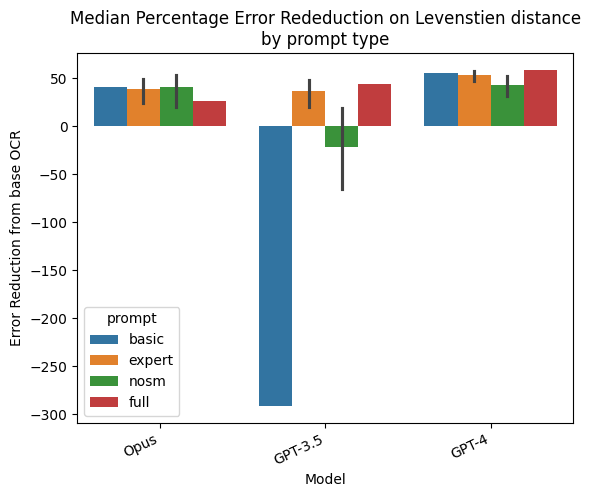

In [42]:
plot_df = melted_df.loc[(melted_df['statistic']=='lev_dist') & 
                        (melted_df['prompt']!='claude') & 
                        (melted_df['type']!='boros_basic__gpt-4-turbo-preview') #&
                      #  (melted_df['aggregate']=='median')
                        ]

temp = plot_df[plot_df['prompt']=='full'].copy()

temp['rank'] = temp['value'].rank()

plot_df = plot_df.merge(temp[['model_name', 'rank']], on = 'model_name').sort_values('rank')

sns.barplot(data = plot_df, x = 'model_name', y = 'value', hue = 'prompt')
plt.xticks(rotation = 25, ha = 'right')
plt.title('Median Percentage Error Rededuction on Levenstien distance\nby prompt type')
plt.xlabel("Model")
plt.ylabel("Error Reduction from base OCR")

plt.savefig(os.path.join(save_figs,"error_reduction.pdf"))
plt.show()

In [46]:
benchmarks  = pd.read_csv('data/benchmarks.csv', index_col = 'benchmark').T

benchmarks['model_id'] = model_name_code

benchmarks = benchmarks.reset_index().merge(plot_df.loc[plot_df['prompt']=='full', ['value', 'model']], 
                               left_on = 'model_id', right_on = 'model').drop(['model', 'model_id'], axis = 1).rename(columns={'index':'model_name',
                                                                                                                 'value':'CLOCR'})

benchmarks.sort_values('CLOCR')

,model_name,MMLU,HellaSwag,ARC-C,WinoGrande,MBPP,DROP,CLOCR
0,Opus,86.8,95.4,96.6,88.5,86.4,83.1,25.91
2,GPT-3.5,70.0,85.5,85.2,81.6,52.2,64.1,43.45
1,GPT-4,86.4,93.3,96.3,87.5,NaN,80.9,58.55


<Axes: xlabel='DROP', ylabel='ARC-C'>

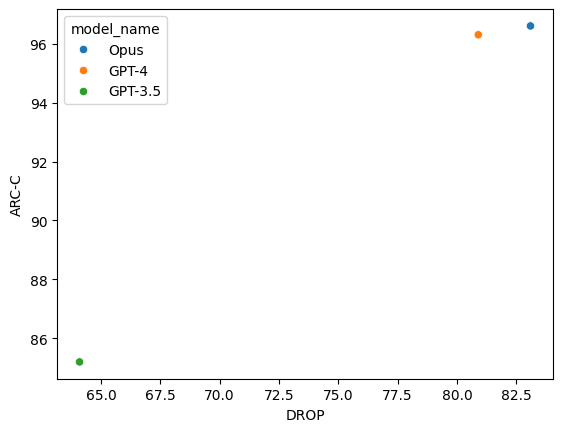

In [49]:
sns.scatterplot(data = benchmarks, x = 'DROP', y = 'ARC-C', hue = 'model_name')

In [47]:
benchmark_names = [ 'MMLU', 'HellaSwag', 'ARC-C', 'WinoGrande', 'MBPP', 'DROP', 'CLOCR']

benchmarks_norm = benchmarks.copy()

for bench_type in benchmark_names:
    benchmarks_norm[bench_type] = (benchmarks_norm[bench_type] - benchmarks_norm[bench_type].min())/(benchmarks_norm[bench_type].max() - benchmarks_norm[bench_type].min())

,MMLU,HellaSwag,ARC-C,WinoGrande,MBPP,CLOCR
MMLU,1.000000,0.983518,0.999998,0.993551,1.0,-0.063954
HellaSwag,0.983518,1.000000,0.983918,0.997677,1.0,-0.243341
ARC-C,0.999998,0.983918,1.000000,0.993800,1.0,-0.066175
WinoGrande,0.993551,0.997677,0.993800,1.000000,1.0,-0.176700
MBPP,1.000000,1.000000,1.000000,1.000000,1.0,-1.000000
CLOCR,-0.063954,-0.243341,-0.066175,-0.176700,-1.0,1.000000


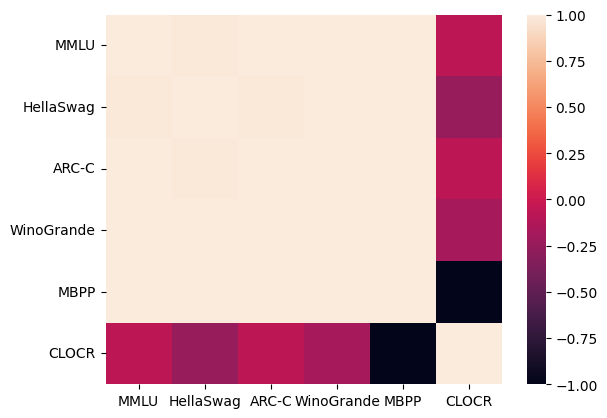

In [48]:
sns.heatmap(data = benchmarks_norm.drop(['DROP'], axis = 1).set_index('model_name').corr())

benchmarks_norm.drop([ 'DROP'], axis = 1).set_index('model_name').corr()

Text(0, 0.5, 'Cross model corellation')

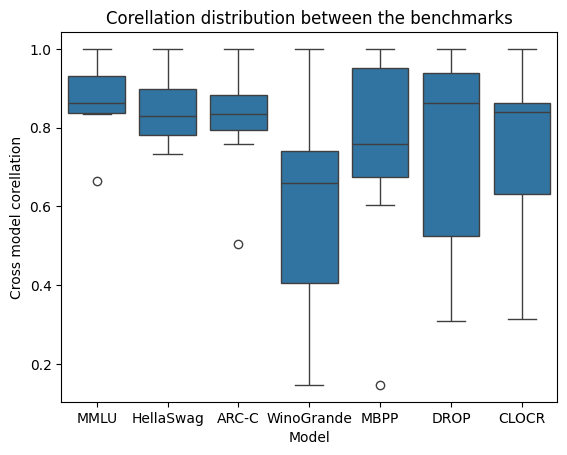

In [126]:
test = benchmarks_norm.set_index('model_name').corr(method = 'pearson').reset_index().melt(id_vars='index')

sns.boxplot(data = test, x = 'variable', y ='value')
plt.title('Corellation distribution between the benchmarks')
plt.xlabel("Model")
plt.ylabel("Cross model corellation")

       joke context  correct
0   chicken      no        0
1   chicken     yes      100
2  combined      no      100
3  combined     yes      100
4       dog      no       60
5       dog     yes       98


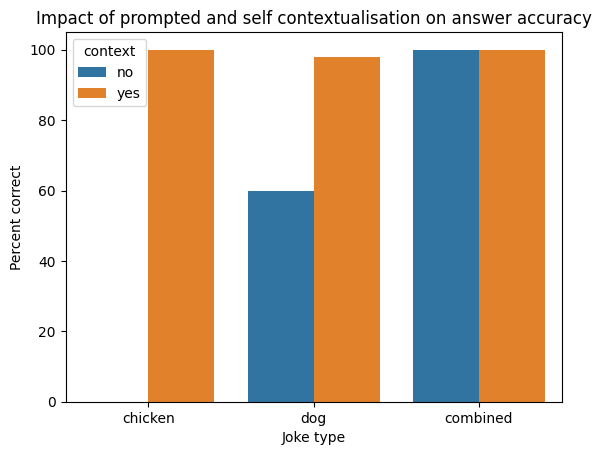

In [30]:
context_results = pd.read_csv("does_LM_use_context_results.csv")

#context_results['joke'] = context_results['joke'].replace('dog', 'Dog has no nose')
#context_results['joke'] = context_results['joke'].replace('chicken', 'Chicken cross the road?')

context_results['correct'] = context_results['correct'].astype(int)

print(context_results.groupby(['joke','context'])['correct'].sum().reset_index())

sns.barplot(data = context_results.groupby(['joke','context'])['correct'].sum().reset_index(),
            x = 'joke', y = 'correct', hue = 'context', order=["chicken", "dog", "combined"])
plt.title('Impact of prompted and self contextualisation on answer accuracy')
#plt.xticks(rotation = 25, ha = 'right')
plt.xlabel('Joke type')
plt.ylabel('Percent correct')
plt.savefig(os.path.join(save_figs,"socio_cultural.pdf"))
plt.show()

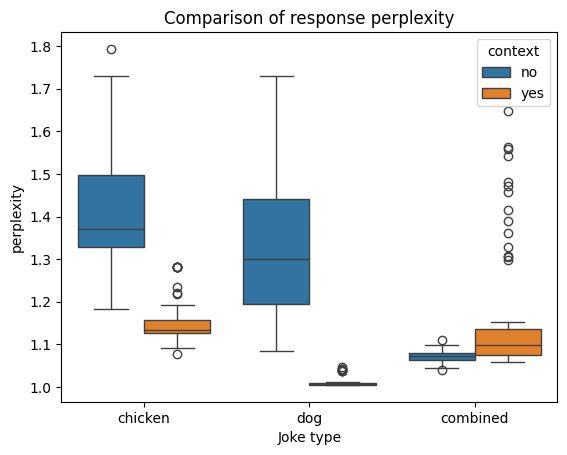

In [26]:
sns.boxplot(data = context_results,
            x = 'joke', y = 'perplexity', hue = 'context', order=["chicken", "dog", "combined"])
plt.title('Comparison of response perplexity')
plt.xlabel('Joke type')
plt.savefig(os.path.join(save_figs,"socio_cultural_perplex.pdf"))
plt.show()